In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
pbp_path = "/content/drive/Othercomputers/My Mac/hacklytics-nhl-dashboard/data/nhl_pbp20192020.csv"
shifts_path = "/content/drive/Othercomputers/My Mac/hacklytics-nhl-dashboard/data/nhl_shifts20192020.csv"
pbp = pd.read_csv(pbp_path)
shifts = pd.read_csv(shifts_path)

In [15]:
pbp['home_max_goal'] = pbp.groupby('Game_Id')['Home_Score'].transform('max')
pbp['away_max_goal'] = pbp.groupby('Game_Id')['Away_Score'].transform('max')

pbp['win'] = np.where(pbp['home_max_goal'] > pbp['away_max_goal'], 1, 0)

pbp['total_seconds_elapsed'] = ((pbp['Period'] - 1) * 1200) + pbp["Seconds_Elapsed"]
pbp['time_remaining'] = 3600 - pbp['total_seconds_elapsed']

pbp['score_diff'] = pbp['Home_Score'] - pbp['Away_Score']

pbp['skater_diff'] = pbp['Home_Players'] - pbp['Away_Players']

pbp['goalie_pulled'] = np.where(pbp['Home_Players'] < 5, 1, 0)

pbp['power_play'] = np.where((pbp['Home_Players'] > pbp['Away_Players']) | (pbp['Away_Players'] > pbp['Home_Players']), 1, 0)

pbp['goal_diff_last_5min'] = pbp.groupby('Game_Id')['score_diff'].rolling(window=10, min_periods=1).mean().reset_index(0, drop=True)

shifts_agg = shifts.groupby(['Game_Id', 'Player_Id'])['Duration'].sum().reset_index()

for col in ['p1_ID', 'p2_ID', 'p3_ID']:
    pbp = pbp.merge(shifts_agg, left_on=['Game_Id', col], right_on=['Game_Id', 'Player_Id'], how='left', suffixes=('', f'_{col}'))

pbp['ice_time'] = pbp[['Duration', 'Duration_p2_ID', 'Duration_p3_ID']].sum(axis=1, skipna=True)
pbp['ice_time'] = pbp['ice_time'].fillna(0)
pbp.drop(columns=['Duration', 'Duration_p2_ID', 'Duration_p3_ID'], inplace=True)

wp_df = pbp[['Game_Id', 'p1_name', 'Ev_Team', 'time_remaining', 'score_diff', 'skater_diff', 'goalie_pulled', 'power_play', 'goal_diff_last_5min', 'ice_time', 'win']]
wp_df = wp_df.dropna()

In [27]:
train_games, test_games = train_test_split(wp_df['Game_Id'].unique(), test_size=0.3, random_state=2142)
train_df = wp_df[wp_df['Game_Id'].isin(train_games)]
test_df = wp_df[wp_df['Game_Id'].isin(test_games)]

X_train = train_df.drop(['win', 'p1_name', 'Ev_Team', 'Game_Id'], axis=1)
Y_train = train_df[['win']]

X_test = test_df.drop(['win', 'p1_name', 'Ev_Team', 'Game_Id'], axis=1)
Y_test = test_df[['win']]

sm = SMOTE(random_state=2142)
X_train_res, Y_train_res = sm.fit_resample(X_train, Y_train)

In [28]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=100, max_depth=5, learning_rate=0.1)
xgb_model.fit(X_train_res, Y_train_res.values.ravel())

Y_pred = xgb_model.predict(X_test)
Y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:42:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [31]:
accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
roc_auc = roc_auc_score(Y_test, Y_pred_proba)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')


Accuracy: 0.7143
Precision: 0.7050
Recall: 0.7793
ROC-AUC: 0.8074


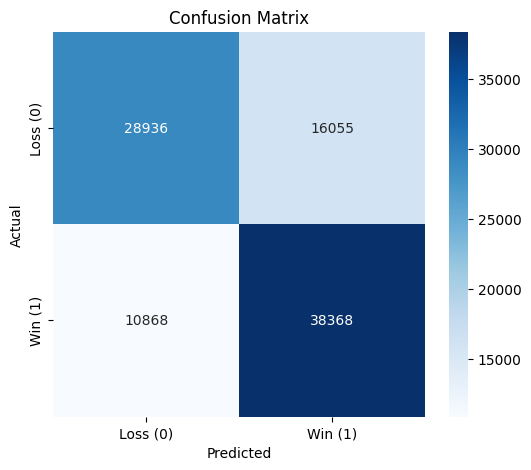

In [30]:
cm = confusion_matrix(Y_test, Y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Loss (0)", "Win (1)"], yticklabels=["Loss (0)", "Win (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

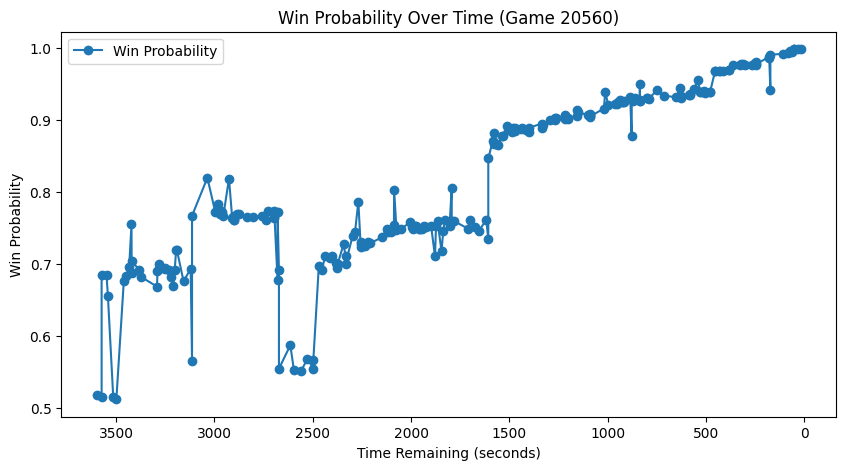

In [39]:
import matplotlib.pyplot as plt
wp_df["win_probability"] = xgb_model.predict_proba(wp_df.drop(['win', 'p1_name', 'Ev_Team', 'Game_Id'], axis=1))[:, 1]
game_id = 20560
game_events = wp_df[wp_df["Game_Id"] == game_id]

plt.figure(figsize=(10, 5))
plt.plot(game_events["time_remaining"], game_events["win_probability"], label="Win Probability", marker="o")
plt.xlabel("Time Remaining (seconds)")
plt.ylabel("Win Probability")
plt.title(f"Win Probability Over Time (Game {game_id})")
plt.legend()
plt.gca().invert_xaxis()
plt.show()


In [44]:
import plotly.graph_objects as go
import pandas as pd

game_events["win_probability_smooth"] = game_events["win_probability"].ewm(span=15, adjust=False).mean()

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=game_events["time_remaining"],
    y=game_events["win_probability_smooth"],
    mode="lines",
    name="Extra Smooth Win Probability",
    line=dict(color="blue", width=2)
))

fig.update_layout(
    title="Extra Smooth Win Probability Over Time (Game 20560)",
    xaxis_title="Time Remaining (seconds)",
    yaxis_title="Win Probability",
    xaxis=dict(autorange="reversed"),
    template="plotly_white"
)

fig.show()
